## Linking the febrl4 datasets

See A.2 [here](https://arxiv.org/pdf/2008.04443.pdf) and [here](https://recordlinkage.readthedocs.io/en/latest/ref-datasets.html) for the source of this data.

It consists of two datasets, A and B, of 5000 records each, with each record in dataset A having a corresponding record in dataset B. The aim will be to capture as many of those 5000 true links as possible, with minimal false linkages.

It is worth noting that we should not necessarily expect to capture _all_ links. There are some links that although we know they _do_ correspond to the same person, the data is so mismatched between them that we would not reasonably expect a model to link them, and indeed should a model do so may indicate that we have overengineered things using our knowledge of true links, which will not be a helpful reference in situations where we attempt to link unlabelled data, as will usually be the case.

### Exploring data and defining model

Firstly let's read in the data and have a little look at it

In [1]:
import pandas as pd 
import altair as alt
from IPython.display import IFrame
alt.renderers.enable('mimetype')

def read_and_prepare(fn):
    df = pd.read_csv(
        fn,
        delimiter=", ",
        dtype={"date_of_birth": str},
        engine="python"
    )
    df["cluster"] = df["rec_id"].apply(lambda x: "-".join(x.split('-')[:2]))
    return df
dfs = [
    read_and_prepare(f"./data/febrl/dataset4{dataset}.csv")
    for dataset in ["a", "b"]
]

display(dfs[0].head(2))
display(dfs[1].head(2))

rec_id given_name  surname  street_number          address_1   
0  rec-1070-org   michaela  neumann            8.0     stanley street  \
1  rec-1016-org   courtney  painter           12.0  pinkerton circuit   

    address_2         suburb  postcode state date_of_birth  soc_sec_id   
0       miami  winston hills      4223   nsw      19151111     5304218  \
1  bega flats      richlands      4560   vic      19161214     4066625   

    cluster  
0  rec-1070  
1  rec-1016

rec_id given_name surname  street_number      address_1  address_2   
0   rec-561-dup-0      elton     NaN            3.0  light setreet   pinehill  \
1  rec-2642-dup-0   mitchell   maxon           47.0  edkins street  lochaoair   

       suburb  postcode state date_of_birth  soc_sec_id   cluster  
0  windermere      3212   vic      19651013     1551941   rec-561  
1  north ryde      3355   nsw      19390212     8859999  rec-2642

Next, to better understand which variables will prove useful in linking, we have a look at how populated each column is, as well as the distribution of unique values within each

In [2]:
from splink.duckdb.duckdb_linker import DuckDBLinker

basic_settings = {
    "unique_id_column_name": "rec_id",
    "link_type": "link_only",
    # NB as we are linking one-one, we know the probability that a random pair will be a match
    # hence we could set:
    # "probability_two_random_records_match": 1/5000,
    # however we will not specify this here, as we will use this as a check that
    # our estimation procedure returns something sensible
}

linker = DuckDBLinker(dfs, basic_settings)

In [3]:
linker.missingness_chart()

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


In [4]:
cols_to_profile = list(dfs[0].columns)
cols_to_profile = [col for col in cols_to_profile if col not in ("rec_id", "cluster")]
linker.profile_columns(cols_to_profile)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


Next let's come up with some candidate blocking rules, which define which record comparisons are generated, and have a look at how many comparisons each will generate.

For blocking rules that we use in prediction, our aim is to have the union of all rules cover all true matches, whilst avoiding generating so many comparisons that it becomes computationally intractable - i.e. each true match should have at least _one_ of the following conditions holding.

In [5]:
blocking_rules = [
    "l.given_name = r.given_name AND l.surname = r.surname",
    "l.date_of_birth = r.date_of_birth",
    "l.soc_sec_id = r.soc_sec_id",
    "l.state = r.state AND l.address_1 = r.address_1",
    "l.street_number = r.street_number AND l.address_1 = r.address_1",
    "l.postcode = r.postcode",
]
linker.cumulative_num_comparisons_from_blocking_rules_chart(blocking_rules)

<VegaLite 4 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/troubleshooting.html


The broadest rule, having a matching postcode, unsurpisingly gives the largest number of comparisons.
For this small dataset we still have a very manageable number, but if it was larger we might have needed to include a further `AND` condition with it to break the number of comparisons further.

Now we get the full settings by including the blocking rules, as well as deciding the actual comparisons we will be including in our model.

We will define two models, each with a separate linker with different settings, so that we can compare performance. One will be a very basic model, whilst the other will include a lot more detail.

In [10]:
import splink.duckdb.duckdb_comparison_level_library as cll
import splink.duckdb.duckdb_comparison_library as cl
import splink.duckdb.duckdb_comparison_template_library as ctl

# the simple model only considers a few columns, and only two comparison levels for each
simple_model_settings = {
    **basic_settings,
    "blocking_rules_to_generate_predictions": blocking_rules,
    "comparisons": [
        cl.exact_match("given_name", term_frequency_adjustments=True),
        cl.exact_match("surname", term_frequency_adjustments=True),
        cl.exact_match("street_number", term_frequency_adjustments=True),
    ],
    "retain_intermediate_calculation_columns": True,
}
# the detailed model considers more columns, using the information we saw in the exploratory phase
# we also include further comparison levels to account for typos and other differences
detailed_model_settings = {
    **basic_settings,
    "blocking_rules_to_generate_predictions": blocking_rules,
    "comparisons": [
        ctl.name_comparison("given_name", term_frequency_adjustments_name=True),
        ctl.name_comparison("surname", term_frequency_adjustments_name=True),
        cl.levenshtein_at_thresholds("date_of_birth", [1, 2]),
        cl.levenshtein_at_thresholds("soc_sec_id", [1, 2]),
        cl.exact_match("street_number", term_frequency_adjustments=True),
        cl.levenshtein_at_thresholds("postcode", [1, 2], term_frequency_adjustments=True),
        # we don't consider further location columns as they will be strongly correlated with postcode
    ],
    "retain_intermediate_calculation_columns": True,
}


linker_simple = DuckDBLinker(dfs, simple_model_settings)
linker_detailed = DuckDBLinker(dfs, detailed_model_settings)

### Estimating model parameters

We need to furnish our models with parameter estimates so that we can generate results. We will focus on the detailed model, generating the values for the simple model at the end

We can instead estimate the probability two random records match, and compare with the known value of 1/5000 = 0.0002, to see how well our estimation procedure works.

To do this we come up with some deterministic rules - the aim here is that we generate very few false positives (i.e. we expect that the majority of records with at least one of these conditions holding are true matches), whilst also capturing the majority of matches - our guess here is that these two rules should capture 80% of all matches.

In [11]:
deterministic_rules = [
    "l.soc_sec_id = r.soc_sec_id",
    "l.given_name = r.given_name and l.surname = r.surname and l.date_of_birth = r.date_of_birth",
]

linker_detailed.estimate_probability_two_random_records_match(deterministic_rules, recall=0.8)

Probability two random records match is estimated to be  0.000238.
This means that amongst all possible pairwise record comparisons, one in 4,195.51 are expected to match.  With 25,000,000 total possible comparisons, we expect a total of around 5,958.75 matching pairs


Even playing around with changing these deterministic rules, or the nominal recall leaves us with an answer which is pretty close to our known value

Next we estimate `u` and `m` values for each comparison, so that we can move to generating predictions

In [ ]:
linker_detailed.estimate_u_using_random_sampling(max_pairs=1e7)

When training the `m` values using expectation maximisation, we need somre more blocking rules to reduce the total number of comparisons. For each rule, we want to ensure that we have neither proportionally too many matches, or too few.

We must run this multiple times using different rules so that we can obtain estimates for all comparisons - if we block on e.g. `date_of_birth`, then we cannot compute the `m` values for the `date_of_birth` comparison, as we have only looked at records where these match.

In [9]:
session_dob = linker_detailed.estimate_parameters_using_expectation_maximisation(
    "l.date_of_birth = r.date_of_birth"
)
session_pc = linker_detailed.estimate_parameters_using_expectation_maximisation(
    "l.postcode = r.postcode"
)


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.date_of_birth = r.date_of_birth

Parameter estimates will be made for the following comparison(s):
    - Given name
    - Surname
    - soc_sec_id
    - street_number
    - postcode

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - date_of_birth

Iteration 1: Largest change in params was 0.529 in probability_two_random_records_match
Iteration 2: Largest change in params was 0.00321 in probability_two_random_records_match
Iteration 3: Largest change in params was 2.92e-05 in the m_probability of soc_sec_id, level `All other comparisons`

EM converged after 3 iterations

Your model is not yet fully trained. Missing estimates for:
    - date_of_birth (no m values are trained).

----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.postcode = r.postcode

Parameter estima

If we wish we can have a look at how our parameter estimates changes over these training sessions

In [10]:
# session_dob.m_u_values_interactive_history_chart()

For variables that aren't used in the `m`-training blocking rules, we have two estimates --- one from each of the training sessions (see for example `street_number`). We can have a look at how the values compare between them, to ensure that we don't have drastically different values, which may be indicative of an issue.

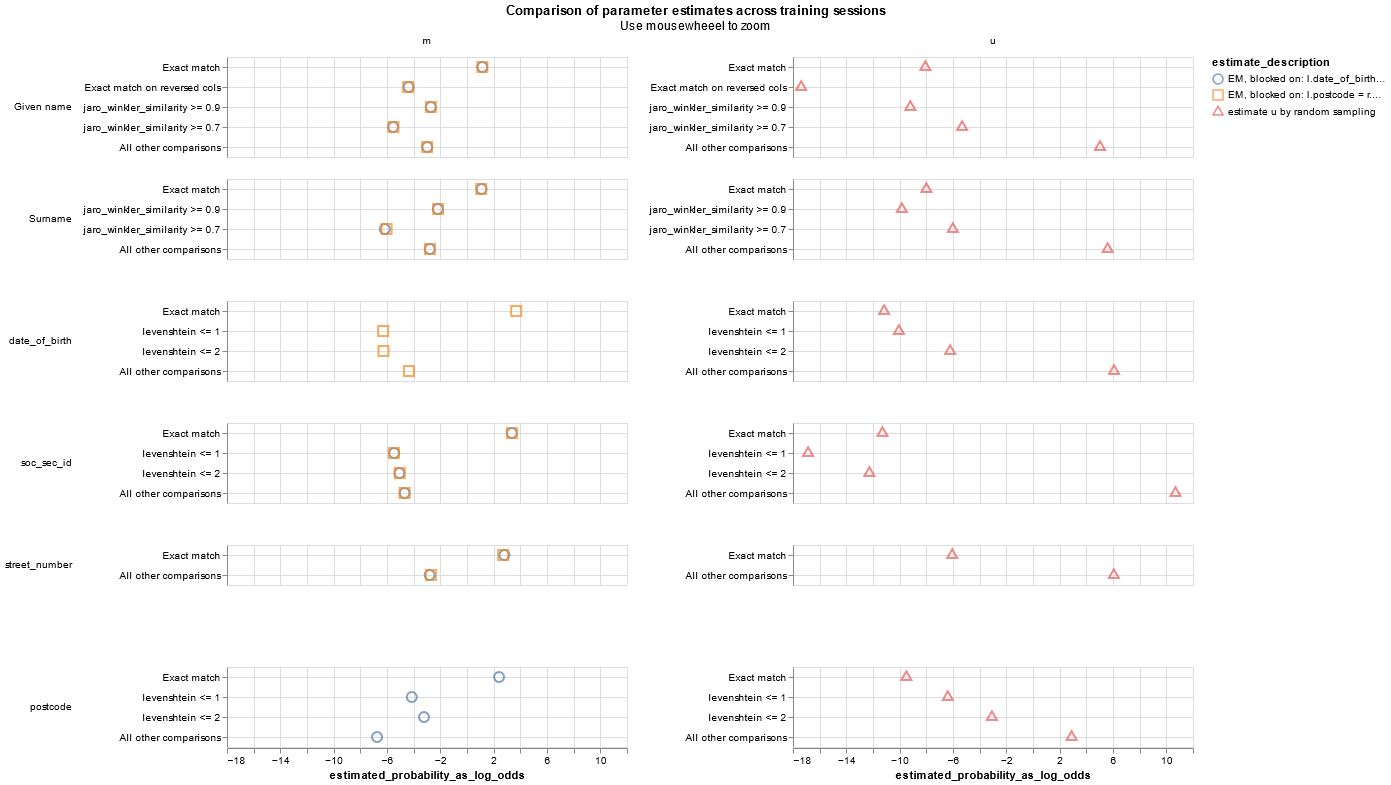

In [11]:
linker_detailed.parameter_estimate_comparisons_chart()

We repeat our parameter estimations for the simple model in much the same fashion

In [12]:
linker_simple.estimate_probability_two_random_records_match(deterministic_rules, recall=0.8)
linker_simple.estimate_u_using_random_sampling(max_pairs=1e7)
session_ssid = linker_simple.estimate_parameters_using_expectation_maximisation(
    "l.given_name = r.given_name"
)
session_pc = linker_simple.estimate_parameters_using_expectation_maximisation(
    "l.street_number = r.street_number"
)
# linker_simple.parameter_estimate_comparisons_chart()

Probability two random records match is estimated to be  0.000238.
This means that amongst all possible pairwise record comparisons, one in 4,195.51 are expected to match.  With 25,000,000 total possible comparisons, we expect a total of around 5,958.75 matching pairs
----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - given_name (no m values are trained).
    - surname (no m values are trained).
    - street_number (no m values are trained).

----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.given_name = r.given_name

Parameter estimates will be made for the following comparison(s):
    - surname
    - street_number

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - given_name

Iteration 1: Largest change in params was -0.0987 in the m_probabi

In [13]:
# import json
# we can have a look at the full settings if we wish, including the values of our estimated parameters:
# print(json.dumps(linker_detailed._settings_obj.as_dict(), indent=2))
# we can also get a handy summary of of the model in an easily readable format if we wish:
# print(linker_detailed._settings_obj.human_readable_description)
# (we suppress output here for brevity)

We can now visualise some of the details of our models. We can look at the match weights, which tell us the relative importance for/against a match for each of our comparsion levels.

Comparing the two models will show the added benefit we get in the more detailed model --- what in the simple model is classed as 'all other comparisons' is instead broken down further, and we can see that the detail of how this is broken down in fact gives us quite a bit of useful information about the likelihood of a match.

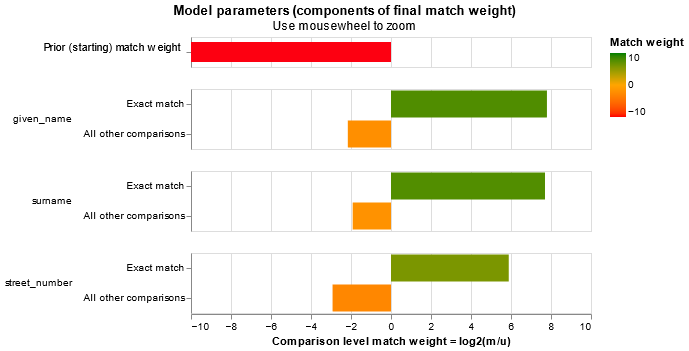

In [14]:
linker_simple.match_weights_chart()

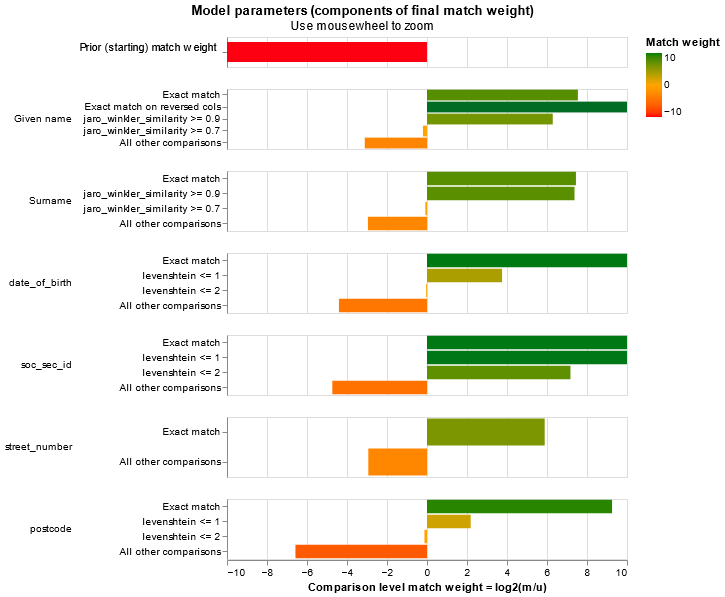

In [15]:
linker_detailed.match_weights_chart()

As well as the match weights, which give us an idea of the overall effect of each comparison level, we can also look at the individual `u` and `m` parameter estimates, which tells us about the prevalence of coincidences and mistakes (for further details/explanation about this see [this article](https://www.robinlinacre.com/maths_of_fellegi_sunter/)). We might want to revise aspects of our model based on the information we ascertain here.

Note however that some of these values are very small, which is why the match weight chart is often more useful for getting a decent picture of things.

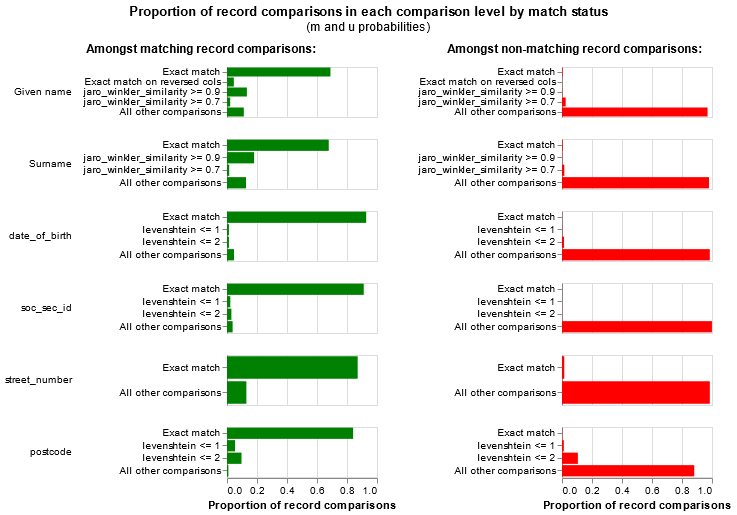

In [16]:
# linker_simple.m_u_parameters_chart()
linker_detailed.m_u_parameters_chart()

It is also useful to have a look at unlinkable records - these are records which do not contain enough information to be linked at some match probability threshold. We can figure this out be seeing whether records are able to be matched with themselves.

This is of course relative to the information we have put into the model - we see that in our simple model, at a 99% match threshold nearly 10% of records are unlinkable, as we have not included enough information in the model for distinct records to be adequately distinguished; this is not an issue in our more detailed model.

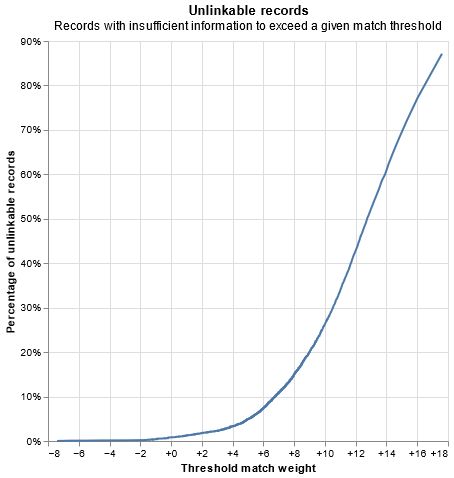

In [17]:
linker_simple.unlinkables_chart()

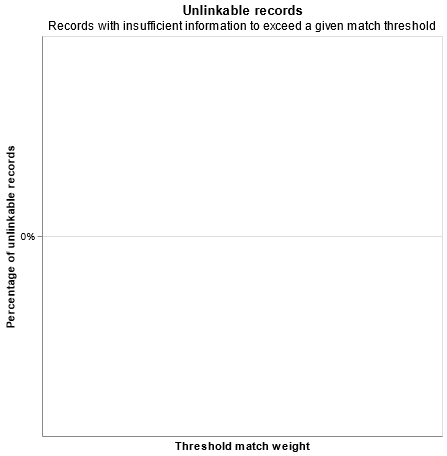

In [18]:
linker_detailed.unlinkables_chart()

Our simple model doesn't do _terribly_, but suffers if we want to have a high match probability --- to be 99% certain of matches we have ~10% of records that we will be unable to link.

Our detailed model, however, has enough nuance that we can at least self-link records.

### Predictions

Now that we have had a look into the details of the models, we will focus on only our more detailed model, which should be able to capture more of the genuine links in our data

In [19]:
predictions = linker_detailed.predict()
df_predictions = predictions.as_pandas_dataframe()
df_predictions.head(5)

match_weight  match_probability source_dataset_l      rec_id_l  \
0     42.077751                1.0               _a  rec-1016-org   
1     50.653290                1.0               _a  rec-1288-org   
2     32.748771                1.0               _a   rec-298-org   
3     49.012108                1.0               _a  rec-2404-org   
4     30.096869                1.0               _a   rec-453-org   

  source_dataset_r        rec_id_r given_name_l given_name_r surname_l  \
0               _b  rec-1016-dup-0     courtney     courtney   painter   
1               _b  rec-1288-dup-0      vanessa      vanessa      parr   
2               _b   rec-298-dup-0        blake        blake     howie   
3               _b  rec-2404-dup-0    blakeston    blakeston   broadby   
4               _b   rec-453-dup-0       edward       edward   denholm   

  surname_r  ...  bf_street_number  bf_tf_adj_street_number  postcode_l  \
0   painter  ...         59.013018                 0.647003        4560   
1      parr  ...         59.013018                70.523279        2135   
2     howie  ...         59.013018                 0.418536        6017   
3   broadby  ...         59.013018                 4.029902        3083   
4   denholm  ...         59.013018                 0.548819        4221   

   postcode_r  gamma_postcode  tf_postcode_l  tf_postcode_r  bf_postcode  \
0        4560               3         0.0030         0.0030   609.446252   
1        2135               3         0.0015         0.0015   609.446252   
2        6071               1         0.0005         0.0005     0.914304   
3        3083               3         0.0011         0.0011   609.446252   
4        4221               3         0.0017         0.0017   609.446252   

   bf_tf_adj_postcode  match_key  
0            0.459895          0  
1            0.919790          0  
2            1.000000          0  
3            1.254259          0  
4            0.811580          0  

[5 rows x 46 columns]

We can see how our model performs at different probability thresholds, with a couple of options depending on the space we wish to view things

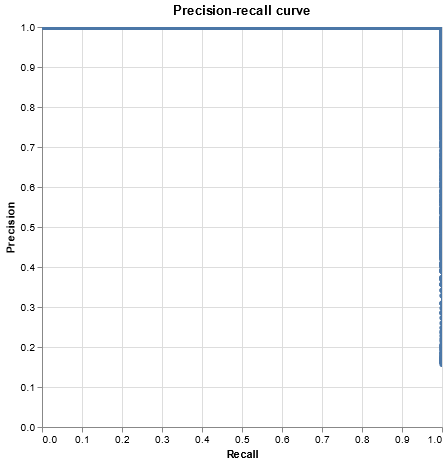

In [20]:
# linker_detailed.roc_chart_from_labels_column("cluster")
linker_detailed.precision_recall_chart_from_labels_column("cluster")

and we can easily see how many individuals we identify and link by looking at clusters generated at some threshold match probability of interest - in this example 99%

In [21]:
clusters = linker_detailed.cluster_pairwise_predictions_at_threshold(predictions, threshold_match_probability=0.99)
df_clusters = clusters.as_pandas_dataframe().sort_values("cluster_id")
df_clusters.groupby("cluster_id").size().value_counts()

Completed iteration 1, root rows count 0


2    4966
1      68
dtype: int64

In this case, we happen to know what the true links are, so we can manually inspect the ones that are doing worst to see what our model is not capturing - i.e. where we have false negatives.

Similarly, we can look at the non-links which are performing the best, to see whether we have an issue with false positives.

Ordinarily we would not have this luxury, and so would need to dig a bit deeper for clues as to how to improve our model, such as manually inspecting records across threshold probabilities, 

In [22]:
df_predictions["cluster_l"] = df_predictions["rec_id_l"].apply(lambda x: "-".join(x.split('-')[:2]))
df_predictions["cluster_r"] = df_predictions["rec_id_r"].apply(lambda x: "-".join(x.split('-')[:2]))
df_true_links = df_predictions[df_predictions["cluster_l"] == df_predictions["cluster_r"]].sort_values("match_probability")

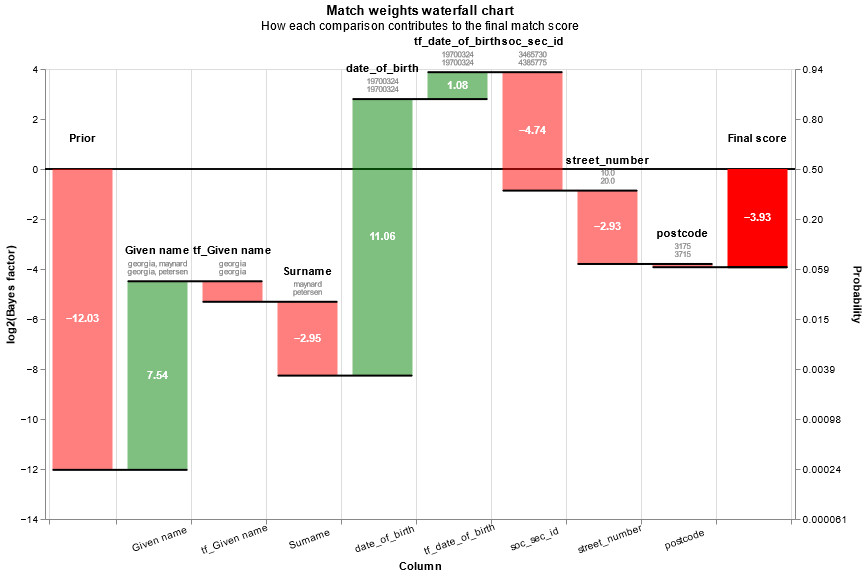

In [23]:
records_to_view = 3
linker_detailed.waterfall_chart(df_true_links.head(records_to_view).to_dict(orient="records"))

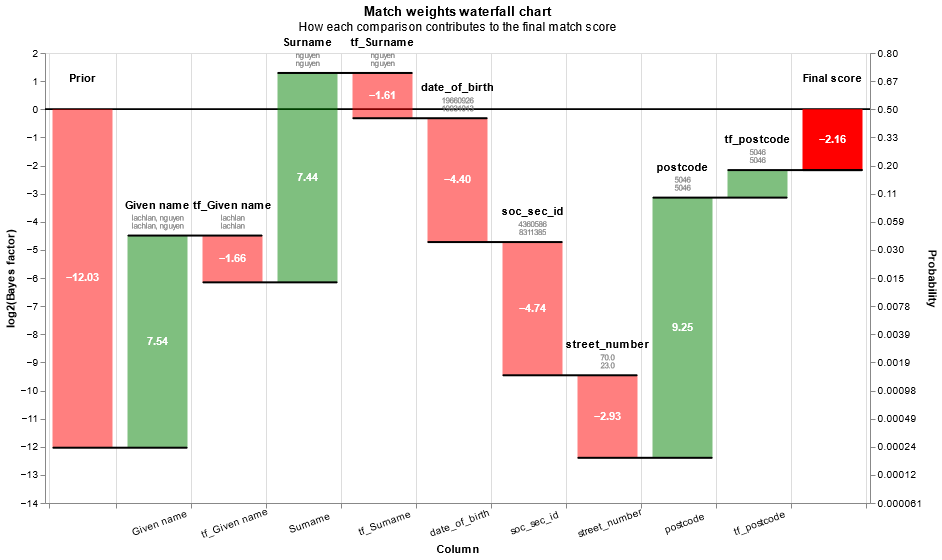

In [24]:
df_non_links = df_predictions[df_predictions["cluster_l"] != df_predictions["cluster_r"]].sort_values("match_probability", ascending=False)
linker_detailed.waterfall_chart(df_non_links.head(records_to_view).to_dict(orient="records"))

## Further refinements

Looking at the non-links we have done well in having no false positives at any substantial match probability --- however looking at some of the true links we can see that there are a few that we are not capturing with sufficient match probability.

We can see that there are a few features that we are not capturing/weighting appropriately
* single-character transpostions, particularly in postcode (which is being lumped in with more 'severe typos'/probable non-matches)
* given/sur-names being swapped with typos
* given/sur-names being cross-matches on one only, with no match on the other cross

We will quickly see if we can incorporate these features into a new model. As we are now going into more detail with the inter-relationship between given name and surname, it is probably no longer sensible to model them as independent comparisons, and so we will need to switch to a combined comparison on full name.

In [25]:
def single_transposition_level(column, label_for_charts=None):
    if label_for_charts is None:
        label_for_charts = "Single transposition"
    return {
        # we have the same set of letters, and two levenshtein edits between them - i.e. a single transposition
        "sql_condition": f"jaccard({column}_l, {column}_r) = 1 AND levenshtein({column}_l, {column}_r) = 2",
        "label_for_charts": label_for_charts
    }

# we need to append a full name column to our source data frames
# so that we can use it for term frequency adjustments
dfs[0]["full_name"] = dfs[0]["given_name"] + "_" + dfs[0]["surname"]
dfs[1]["full_name"] = dfs[1]["given_name"] + "_" + dfs[1]["surname"]


extended_model_settings = {
    **basic_settings,
    "blocking_rules_to_generate_predictions": blocking_rules,
    "comparisons": [
        {
            "output_column_name": "Full name",
            "comparison_levels": [
                {
                    "sql_condition": "(given_name_l IS NULL OR given_name_r IS NULL) and (surname_l IS NULL OR surname_r IS NULL)",
                    "label_for_charts": "Null",
                    "is_null_level": True,
                },
                # full name match
                {
                    "sql_condition": "full_name_l = full_name_r",
                    "label_for_charts": "Both names match",
                    "tf_adjustment_column": "full_name",
                    "tf_adjustment_weight": 1.0,
                },
                # typos - keep levels across full name rather than scoring separately
                {
                    "sql_condition": "jaro_winkler_similarity(full_name_l, full_name_r) > 0.9",
                    "label_for_charts": "JW (full name) > 0.9",
                },
                {
                    "sql_condition": "jaro_winkler_similarity(full_name_l, full_name_r) > 0.7",
                    "label_for_charts": "JW (full name) > 0.7",
                },
                # name switched
                {
                    "sql_condition": "given_name_l = surname_r AND surname_l = given_name_r",
                    "label_for_charts": "Names switched",
                },
                # name switched + typo
                {
                    "sql_condition": "jaro_winkler_similarity(given_name_l, surname_r) + jaro_winkler_similarity(surname_l, given_name_r) >= 1.8",
                    "label_for_charts": "switched + jaro_winkler_similarity >= 1.8"
                },
                {
                    "sql_condition": "jaro_winkler_similarity(given_name_l, surname_r) + jaro_winkler_similarity(surname_l, given_name_r) >= 1.4",
                    "label_for_charts": "switched + jaro_winkler_similarity >= 1.4"
                },
                # single name match
                {
                    "sql_condition": "given_name_l = given_name_r",
                    "label_for_charts": "given name matches",
                    "tf_adjustment_column": "given_name",
                    "tf_adjustment_weight": 1.0,
                },
                {
                    "sql_condition": "surname_l = surname_r",
                    "label_for_charts": "surname matches",
                    "tf_adjustment_column": "surname",
                    "tf_adjustment_weight": 1.0,
                },
                # single name cross-match
                {
                    "sql_condition": "given_name_l = surname_r OR surname_l = given_name_r",
                    "label_for_charts": "single name cross-matches"
                },
                # single name typos
                {
                    "sql_condition": "jaro_winkler_similarity(given_name_l, given_name_r) > 0.9",
                    "label_for_charts": "JW (given name) > 0.9",
                },
                {
                    "sql_condition": "jaro_winkler_similarity(surname_l, surname_r) > 0.9",
                    "label_for_charts": "JW (surname) > 0.9",
                },
                # the rest
                cll.else_level()
            ]
        },
        {
            "output_column_name": "Date of birth",
            "comparison_levels": [
                cll.null_level("date_of_birth"),
                cll.exact_match_level("date_of_birth", term_frequency_adjustments=True),
                cll.distance_function_level("date_of_birth", "levenshtein", 1, higher_is_more_similar=False),
                # this is the extra level
                single_transposition_level("date_of_birth"),
                cll.distance_function_level("date_of_birth", "levenshtein", 2, higher_is_more_similar=False),
                cll.else_level()
            ]
        },
        {
            "output_column_name": "Social security ID",
            "comparison_levels": [
                cll.null_level("soc_sec_id"),
                cll.exact_match_level("soc_sec_id", term_frequency_adjustments=True),
                cll.distance_function_level("soc_sec_id", "levenshtein", 1, higher_is_more_similar=False),
                single_transposition_level("soc_sec_id"),
                cll.distance_function_level("soc_sec_id", "levenshtein", 2, higher_is_more_similar=False),
                cll.else_level()
            ]
        },
        {
            "output_column_name": "Street number",
            "comparison_levels": [
                cll.null_level("street_number"),
                cll.exact_match_level("street_number", term_frequency_adjustments=True),
                cll.distance_function_level("street_number", "levenshtein", 1, higher_is_more_similar=False),
                single_transposition_level("street_number"),
                cll.else_level()
            ]
        },
        {
            "output_column_name": "Postcode",
            "comparison_levels": [
                cll.null_level("postcode"),
                cll.exact_match_level("postcode", term_frequency_adjustments=True),
                cll.distance_function_level("postcode", "levenshtein", 1, higher_is_more_similar=False),
                single_transposition_level("postcode"),
                cll.distance_function_level("postcode", "levenshtein", 2, higher_is_more_similar=False),
                cll.else_level()
            ]
        },
        # we don't consider further location columns as they will be strongly correlated with postcode
    ],
    "retain_intermediate_calculation_columns": True,
}

In [26]:
# train
linker_advanced = DuckDBLinker(dfs, extended_model_settings)
linker_advanced.estimate_probability_two_random_records_match(deterministic_rules, recall=0.8)
# we increase target rows to improve accuracy for u values in full name comparison, as we have subdivided the data more finely
linker_advanced.estimate_u_using_random_sampling(max_pairs=1e8)
session_dob = linker_advanced.estimate_parameters_using_expectation_maximisation(
    "l.date_of_birth = r.date_of_birth"
)
session_pc = linker_advanced.estimate_parameters_using_expectation_maximisation(
    "l.postcode = r.postcode"
)

Probability two random records match is estimated to be  0.000238.
This means that amongst all possible pairwise record comparisons, one in 4,195.51 are expected to match.  With 25,000,000 total possible comparisons, we expect a total of around 5,958.75 matching pairs
----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - Full name (no m values are trained).
    - Date of birth (no m values are trained).
    - Social security ID (no m values are trained).
    - Street number (no m values are trained).
    - Postcode (no m values are trained).

----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.date_of_birth = r.date_of_birth

Parameter estimates will be made for the following comparison(s):
    - Full name
    - Social security ID
    - Street number
    - Postcode

Parameter estimates cannot be made for the follo

In [27]:
# linker_advanced.parameter_estimate_comparisons_chart()

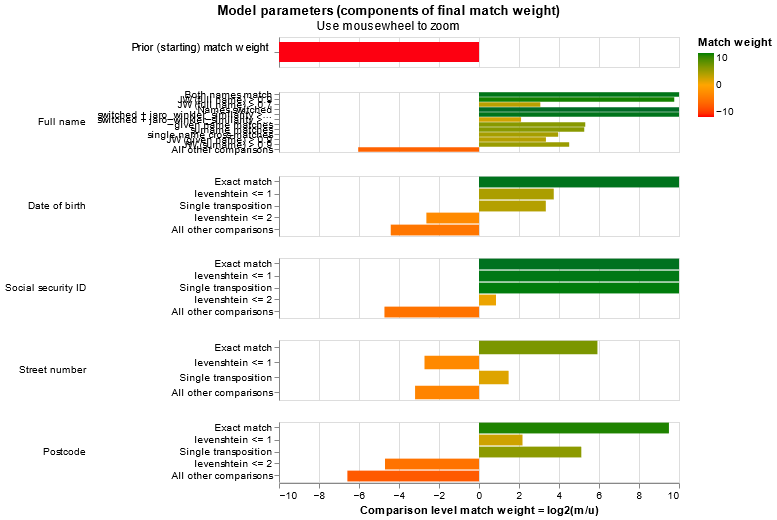

In [28]:
linker_advanced.match_weights_chart()

In [29]:
predictions_adv = linker_advanced.predict()
df_predictions_adv = predictions_adv.as_pandas_dataframe()
clusters_adv = linker_advanced.cluster_pairwise_predictions_at_threshold(predictions_adv, threshold_match_probability=0.99)
df_clusters_adv = clusters_adv.as_pandas_dataframe().sort_values("cluster_id")
df_clusters_adv.groupby("cluster_id").size().value_counts()

Completed iteration 1, root rows count 0


2    4970
1      60
dtype: int64

This is a pretty modest improvement on our previous model - however it is worth re-iterating that we should not necessarily expect to recover _all_ matches, as in several cases it may be unreasonable for a model to have reasonable confidence that two records refer to the same entity.

If we wished to improve matters we could iterate on this process - investigating where our model is not performing as we would hope, and seeing how we can adjust these areas to address these shortcomings.